In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Final

In [2]:
AFFECT_NET: Final[str] = 'affect-net/labels.csv'
KAGGLE_DATA: Final[str] = 'kaggle-data/data.csv'
FILTERED_DATA_PATH: Final[str] = 'processed_data/filtered/affect_net_5_labels.csv'
RAW_AFFECT_DATA_FOLDER: Final[str] = os.path.join(os.getcwd(), 'affect-net/')
RAW_KAGGLE_DATA_FOLDER: Final[str] = os.path.join(os.getcwd(), 'kaggle-data/')


# AffectNet dataset 

In [3]:
affect_net = pd.read_csv(AFFECT_NET)
affect_net.shape[0]

28175

In [4]:
def show_data_labels_bar_plot(data: pd.DataFrame):
    label_counts = data['label'].value_counts().reset_index()
    label_counts.columns = ['label', 'count']

    total_count = label_counts['count'].sum()
    label_counts['percentage'] = (label_counts['count'] / total_count) * 100

    plt.figure(figsize=(8, 6))
    bar_plot = sns.barplot(data=label_counts, x='label', y='count')

    for _, row in label_counts.iterrows():
        bar_plot.text(
            row.name,
            row['count'] + 0.5,
            f"{row['percentage']:.1f}% ({row['count']})",
            ha="center",
            color="black",
            fontsize=8
        )

    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Labels count')

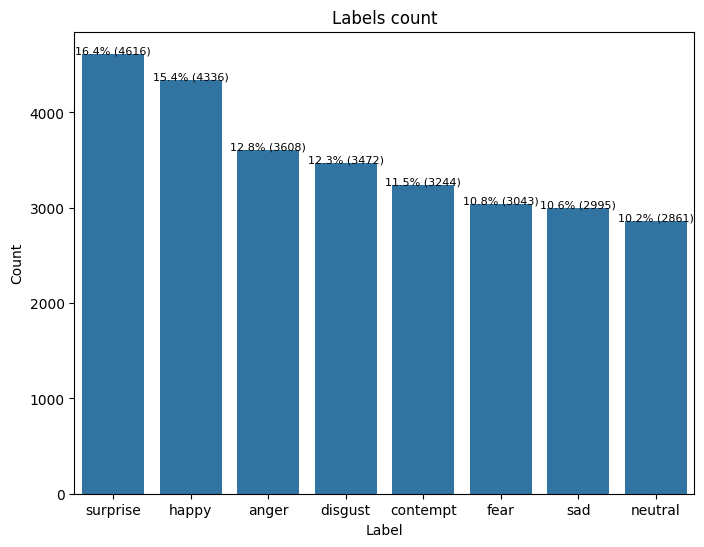

In [5]:
show_data_labels_bar_plot(affect_net)

In [6]:
unnecessary_labels = ('disgust', 'contempt', 'fear')
filtered_df = affect_net[~affect_net['label'].isin(unnecessary_labels)]
filtered_df.loc[filtered_df['label'] == 'anger', 'label'] = 'angry'
filtered_df['pth'] = RAW_AFFECT_DATA_FOLDER + filtered_df['pth'].astype(str)

/var/folders/3t/gyxj9s512yx6klv5c576ykyc0000gn/T/ipykernel_19824/1563111226.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['pth'] = RAW_AFFECT_DATA_FOLDER + filtered_df['pth'].astype(str)


In [7]:
filtered_df.shape[0]

18416

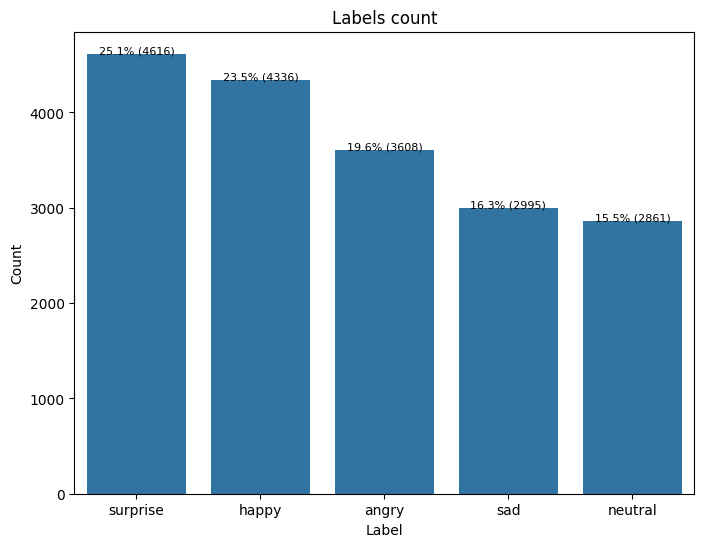

In [8]:
show_data_labels_bar_plot(filtered_df)

# Kaggle dataset

In [ ]:
kaggle_data = pd.read_csv(KAGGLE_DATA)
kaggle_data = kaggle_data[~kaggle_data['label'].isin(['Ahegao'])]
kaggle_data.shape[0]

14248

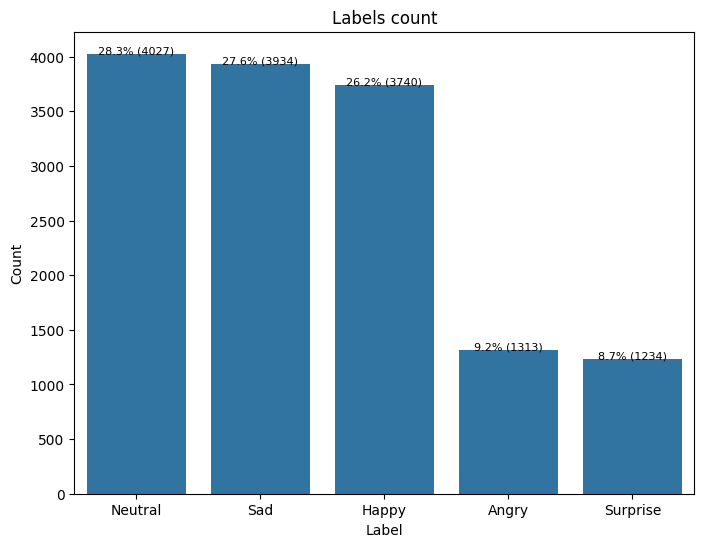

In [126]:
show_data_labels_bar_plot(kaggle_data)

# Working with disbalance

In [127]:
from torchvision import transforms

geom_and_color_augmentation_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(1.0),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2, hue=0.5),
    transforms.ToPILImage(mode='RGB')
])

rotation_augmentation_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=30, translate=(0.3, 0.2)),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToPILImage(mode='RGB')
])


In [128]:
from tqdm import tqdm
augmented_data = pd.DataFrame(columns=['path', 'label'])

for row_idx, row in tqdm(kaggle_data.iterrows()):
    if row['label'] in ['Angry', 'Surprise']:
        label = row['label']
        img = Image.open(f"kaggle-data/{row['path']}")
        img_name = f'{label}-aug-geom-{row_idx}.png'
        dst_path = 'kaggle-data/{label}/{img_name}'

        geom_and_color_augmentation_pipeline(img).save(dst_path.format(label=label, img_name=img_name))
        augmented_data.loc[len(augmented_data)] = [RAW_KAGGLE_DATA_FOLDER + f'{label.lower()}/{img_name}', label.lower()]

        img_name = f'{label}-aug-rot-{row_idx}.png'
        rotation_augmentation_pipeline(img).save(dst_path.format(label=label, img_name=img_name))

        augmented_data.loc[len(augmented_data)] = [RAW_KAGGLE_DATA_FOLDER + f'{label.lower()}/{img_name}', label.lower()]
    augmented_data.loc[len(augmented_data)] = [RAW_KAGGLE_DATA_FOLDER + row['path'].lower(), row['label'].lower()]

14248it [08:05, 29.33it/s]  


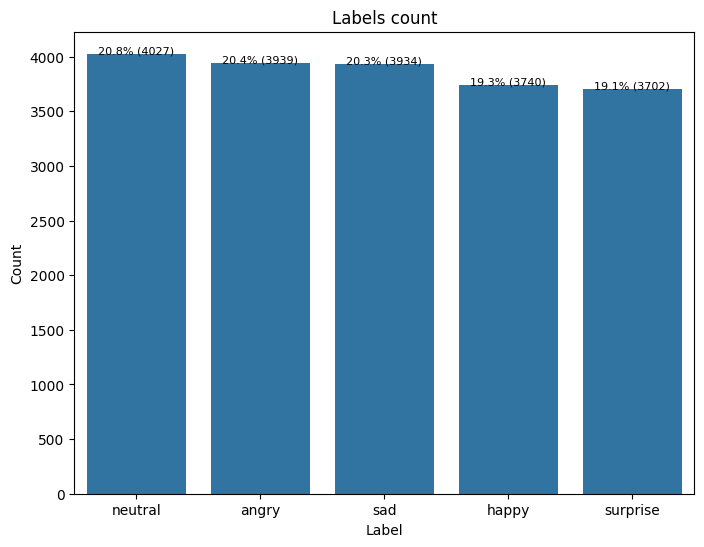

In [129]:
show_data_labels_bar_plot(augmented_data)

# Merging and splitting datasets

In [130]:
size_before_merge = augmented_data.shape[0]
for _, row in filtered_df.iterrows():
     augmented_data.loc[len(augmented_data)] = [row['pth'], row['label']]

assert augmented_data.shape[0] == size_before_merge + filtered_df.shape[0]


In [131]:
from sklearn.model_selection import train_test_split

x, x_test, y, y_test = train_test_split(augmented_data['path'], augmented_data['label'], test_size=0.2, train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, train_size=0.75)

train_data = pd.concat((x_train, y_train), axis=1)
test_data = pd.concat((x_test, y_test), axis=1)
val_data = pd.concat((x_val, y_val), axis=1)

print(train_data.shape[0], test_data.shape[0], val_data.shape[0], augmented_data.shape[0])

assert train_data.shape[0] + test_data.shape[0] + val_data.shape[0] == augmented_data.shape[0]



22654 7552 7552 37758


In [132]:
import shutil


def move_images(data: pd.DataFrame, dst_dir_name: str):
    for row_idx, row in data.iterrows():
        label_name = row['label'].lower()
        image_path = row['path']

        os.makedirs(f'./processed_data/{dst_dir_name}/{label_name}', exist_ok=True)
        shutil.copyfile(image_path, f'./processed_data/{dst_dir_name}/{label_name}/{dst_dir_name}-{label_name}-{row_idx}.png')

move_images(train_data, 'train')
move_images(test_data, 'test')
move_images(val_data, 'val')

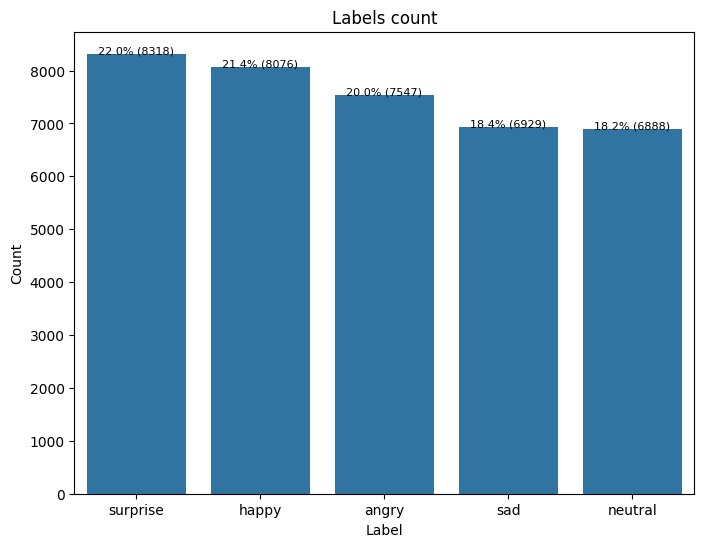

In [134]:
show_data_labels_bar_plot(augmented_data)